In [ ]:
# default_exp core

# core

> Contains functions to run model

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#hide 
%load_ext autoreload
%autoreload 2

In [ ]:
#export
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import os
import pandas as pd
import sys
[sys.path.append(i) for i in ['.', '..']]

[None, None]

In [ ]:
#export
from aquacrop.initialize import *
from aquacrop.timestep import *
from aquacrop.classes import *
from aquacrop import data

In [ ]:
#export
def list_data():
    """
    lists all built-in data files
    """
    path=data.__path__[0]
    
    return os.listdir(path)

In [ ]:
#export 
def get_filepath(filename):
    """
    get selected data file
    """
    filepath = os.path.join(data.__path__[0],filename)
    
    return filepath


In [ ]:
#export 
def get_data(filename, **kwargs):
    """
    get selected data file
    """
    filepath = os.path.join(data.__path__[0],filename)
    
    return np.genfromtxt(filepath,**kwargs)

In [ ]:
#export
def prepare_weather(weatherFilePath):
    """
    function to read in weather data and return a dataframe containing 
    the weather data
    
    *Arguments:*\n
        
    `FileLocations` : `FileLocationsClass`:  input File Locations
        
    `weatherFilePath` : `str` :  file location of weather data



    *Returns:*
    
    `weather_df`: `pandas.DataFrame` :  weather data for simulation period
        
    """
    

    weather_df = pd.read_csv(weatherFilePath,header=0,delim_whitespace=True)
    
    assert len(weather_df.columns) == 7
    
    # rename the columns
    weather_df.columns = str("Day Month Year MinTemp MaxTemp Precipitation ReferenceET").split()
    
    # put the weather dates into datetime format
    weather_df["Date"] = pd.to_datetime(weather_df[['Year','Month','Day']])
    
    # drop the day month year columns
    weather_df = weather_df.drop(["Day","Month","Year"],axis=1)    
    
    # set limit on ET0 to avoid divide by zero errors
    weather_df.ReferenceET.clip(lower=0.1,inplace=True)

    
    return weather_df

In [ ]:
#hide
show_doc(prepare_weather)

<h4 id="prepare_weather" class="doc_header"><code>prepare_weather</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>prepare_weather</code>(**`weatherFilePath`**)

function to read in weather data and return a dataframe containing 
the weather data

*Arguments:*

    
`FileLocations` : `FileLocationsClass`:  input File Locations
    
`weatherFilePath` : `str` :  file location of weather data



*Returns:*

`weather_df`: `pandas.DataFrame` :  weather data for simulation period
    

In [ ]:
#export
class AquaCropModel:
    
    def __init__(self,SimStartTime,SimEndTime,wdf,Soil,Crop,InitWC,
                     IrrMngt=None,FieldMngt=None,FallowFieldMngt=None,
                     Groundwater=None,planting_dates=None,
                     harvest_dates=None,CO2conc=None):
        
        self.SimStartTime = SimStartTime
        self.SimEndTime = SimEndTime
        self.wdf = wdf
        self.Soil = Soil
        self.Crop = Crop
        self.InitWC = InitWC
        self.planting_dates = planting_dates
        self.harvest_dates = harvest_dates
        self.CO2conc = CO2conc
        
        self.IrrMngt = IrrMngt
        self.FieldMngt = FieldMngt
        self.FallowFieldMngt = FallowFieldMngt
        self.Groundwater = Groundwater
        
        if IrrMngt == None:  self.IrrMngt = IrrMngtClass(IrrMethod=0);
        if FieldMngt == None:  self.FieldMngt = FieldMngtClass();
        if FallowFieldMngt == None:  self.FallowFieldMngt = FieldMngtClass();
        if Groundwater == None:  self.Groundwater = GwClass();
        #if InitWC == None:  self.InitWC = InitWCClass();




    def initialize(self,):
        """
        Initialize variables


        """

        # define model runtime
        self.ClockStruct = read_clock_paramaters(self.SimStartTime,self.SimEndTime)

        # get weather data
        self.weather_df = read_weather_inputs(self.ClockStruct,self.wdf)
                
        # read model params
        self.ClockStruct, self.ParamStruct = read_model_parameters(self.ClockStruct,self.Soil,
                                                                   self.Crop,self.weather_df)

        # read irrigation management
        self.ParamStruct = read_irrigation_management(self.ParamStruct,self.IrrMngt,self.ClockStruct)

        # read field management
        self.ParamStruct = read_field_management(self.ParamStruct,self.FieldMngt,self.FallowFieldMngt)

        # read groundwater table
        self.ParamStruct = read_groundwater_table(self.ParamStruct,self.Groundwater,self.ClockStruct)

        # Compute additional variables
        self.ParamStruct.CO2concAdj = self.CO2conc
        self.ParamStruct = compute_variables(self.ParamStruct,self.weather_df,self.ClockStruct)

        # read, calculate inital conditions
        self.ParamStruct, self.InitCond = read_model_initial_conditions(self.ParamStruct,self.ClockStruct,self.InitWC)

        self.ParamStruct = create_soil_profile(self.ParamStruct)

        #self.InitCond.ParamStruct = self.ParamStruct

        Outputs = OutputClass()
        Outputs.Water = np.zeros((len(self.ClockStruct.TimeSpan),3+len(self.InitCond.th)))
        Outputs.Flux = np.zeros((len(self.ClockStruct.TimeSpan),16))
        Outputs.Growth = np.zeros((len(self.ClockStruct.TimeSpan),13))
        Outputs.Final = pd.DataFrame(columns = ['Season','Crop Type','Harvest Date (YYYY/MM/DD)',
                                                'Harvest Date (Step)','Yield (tonne/ha)',
                                                'Seasonal irrigation (mm)'])


        self.Outputs=Outputs
        
         # save model weather to InitCond
        self.weather = self.weather_df.values

        #return self.ClockStruct,self.InitCond,self.Outputs
        return 
    
    
    def step(self,num_steps=1,till_termination=False):

        if till_termination==True:

            while self.ClockStruct.ModelTermination == False:

                self.ClockStruct,self.InitCond,self.ParamStruct,self.Outputs = self.perform_timestep()
        else:

            for i in range(num_steps):

                self.ClockStruct,self.InitCond,self.ParamStruct,self.Outputs = self.perform_timestep()
                
                if self.ClockStruct.ModelTermination: return

        #return self.ClockStruct,self.InitCond,self.Outputs
        return 


    def perform_timestep(self):

        """
        Function to run a single time-step (day) calculation of AquaCrop-OS

        """


        # extract weather data for current timestep
        #weather_step = weather_df[weather_df.Date==ClockStruct.StepStartTime]
        weather_step = self.weather[self.ClockStruct.TimeStepCounter]

        #%% Get model solution %%
        NewCond,ParamStruct,Outputs = solution(self.InitCond,self.ParamStruct,self.ClockStruct,weather_step,self.Outputs)

        #%% Check model termination %%
        ClockStruct = check_model_termination(self.ClockStruct,NewCond)

        #%% Update time step %%
        ClockStruct,InitCond,ParamStruct,Outputs = update_time(ClockStruct,NewCond,ParamStruct,Outputs,self.weather)

        return ClockStruct,InitCond,ParamStruct,Outputs

In [ ]:
#hide
show_doc(AquaCropModel)

<h2 id="AquaCropModel" class="doc_header"><code>class</code> <code>AquaCropModel</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>AquaCropModel</code>(**`SimStartTime`**, **`SimEndTime`**, **`wdf`**, **`Soil`**, **`Crop`**, **`InitWC`**, **`IrrMngt`**=*`None`*, **`FieldMngt`**=*`None`*, **`FallowFieldMngt`**=*`None`*, **`Groundwater`**=*`None`*, **`planting_dates`**=*`None`*, **`harvest_dates`**=*`None`*, **`CO2conc`**=*`None`*)



In [ ]:
def compile_func():
    wdf = prepare_weather(get_filepath('tunis_climate.txt'))
    soil = SoilClass('SandyLoam')
    crop = CropClass('Wheat',PlantingDate='10/01',HarvestDate='05/30')
    irr_mngt = IrrMngtClass(1,SMT=[100]*4,MaxIrrSeason=10)
    print(irr_mngt.MaxIrrSeason)
    init_wc = InitWCClass()
    model = AquaCropModel('1979/01/01','1980/05/31',wdf,soil,crop,InitWC=init_wc,IrrMngt=irr_mngt)
    model.initialize()
    model.step(till_termination=True)
    return model
    
compile_func().Outputs.Final

10


,Season,Crop Type,Harvest Date,Harvest Date (Step),Yield (tonne/ha),Seasonal irrigation (mm)
0,0,Wheat,1980-03-24,447,8.46338,10.0


## Run model for 1 year

### get weather data. Columns must be:

1) whitespace seperated

2) In this order : Day Month Year Tmin(C) Tmax(C) Prcp(mm) Et0(mm)

In [ ]:
wdf = prepare_weather(get_filepath('tunis_climate.txt'))
wdf.Date.min(),wdf.Date.max()

(Timestamp('1979-01-01 00:00:00'), Timestamp('2002-05-31 00:00:00'))

now we have the range of dates in our weather file we have to create our soil and crop

In [ ]:
soil = SoilClass('SandyLoam',dz=[0.05]*12)
soil.profile

,Comp,Layer,dz,dzsum,zBot,zTop,zMid,th_dry,th_wp,th_fc,th_s,Ksat,penetrability,tau
0,0,1.0,0.1,0.1,0.1,0.0,0.05,0.05,0.1,0.22,0.41,1200,100,1
1,1,1.0,0.1,0.2,0.2,0.1,0.15,0.05,0.1,0.22,0.41,1200,100,1
2,2,1.0,0.1,0.3,0.3,0.2,0.25,0.05,0.1,0.22,0.41,1200,100,1
3,3,1.0,0.1,0.4,0.4,0.3,0.35,0.05,0.1,0.22,0.41,1200,100,1
4,4,1.0,0.1,0.5,0.5,0.4,0.45,0.05,0.1,0.22,0.41,1200,100,1
5,5,1.0,0.1,0.6,0.6,0.5,0.55,0.05,0.1,0.22,0.41,1200,100,1
6,6,1.0,0.1,0.7,0.7,0.6,0.65,0.05,0.1,0.22,0.41,1200,100,1
7,7,1.0,0.1,0.8,0.8,0.7,0.75,0.05,0.1,0.22,0.41,1200,100,1
8,8,1.0,0.1,0.9,0.9,0.8,0.85,0.05,0.1,0.22,0.41,1200,100,1
9,9,1.0,0.1,1.0,1.0,0.9,0.95,0.05,0.1,0.22,0.41,1200,100,1


In [ ]:
crop = CropClass('Wheat',PlantingDate='10/10',HarvestDate='05/30'); crop.Zmax

1.5

create model

In [ ]:
gw = GwClass(WaterTable='Y',Method='Constant',dates=['1979/01/01','1990/01/01'],values=[1.5,2])

In [ ]:
model = AquaCropModel('1979/01/01','2002/05/31',wdf,soil,crop,InitWCClass(),Groundwater=gw)

In [ ]:
model.initialize()

In [ ]:
%time model.step(till_termination=True)

CPU times: user 2.14 s, sys: 3.99 ms, total: 2.15 s
Wall time: 2.15 s


<AxesSubplot:>

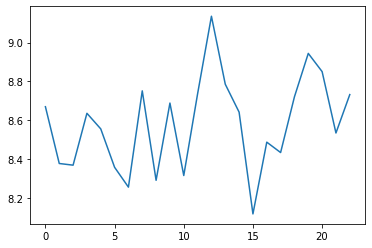

In [ ]:
model.Outputs.Final['Yield (tonne/ha)'].plot()